In [1]:
import numpy as np
import json
import torch
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.append(r'C:\Users\parax\Dropbox\Programming\Python\magnetic_field_reconstruction\2D')
from Magnetisation.Propagator import Propagator
from Magnetisation.Generator import generator_CNN, generator_CNN_J
from Magnetisation.Train import Magnetisation_CNN_training
from Magnetisation.utils import LoadData

# Load the curren data
Bz = 1e-4*np.loadtxt('../../data/Current/Nb_wire_Bz.txt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


c:\Users\parax\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define the dictionary for the forward propagation
unit_conversion = 1e-18 / 9.27e-24
PropagationOptions = dict()
PropagationOptions['PixelSize'] = 4*108e-09
PropagationOptions['ImageShape'] = 256
PropagationOptions['NV'] = dict()
PropagationOptions['NV']['FindTheta']= False
PropagationOptions['NV']['Theta'] = 0
PropagationOptions['NV']['FindPhi']= False
PropagationOptions['NV']['Phi'] = 0
PropagationOptions['NV']['Height'] = 100e-09
PropagationOptions['Magnetisation'] = dict()
PropagationOptions['Magnetisation']['FindTheta']=False
PropagationOptions['Magnetisation']['Theta'] = 0
PropagationOptions['Magnetisation']['FindPhi']= False
PropagationOptions['Magnetisation']['Phi'] = 0
PropagationOptions['FFT'] = dict()
PropagationOptions["FFT"]["PaddingFactor"]= 2
PropagationOptions["FFT"]["performPadding"]= False
PropagationOptions["FFT"]["PaddingMode"] = 'constant'
PropagationOptions['FFT']['Extended'] = False
PropagationOptions['FFT']['Extention'] = 100
PropagationOptions['FFT']['Filter'] = dict()
PropagationOptions['FFT']['Filter']['useHanning'] = False 
PropagationOptions['FFT']['Filter']['useHighCutoff'] = False
PropagationOptions['FFT']['Filter']['useLowCutoff'] = False
PropagationOptions['FFT']['Filter']['LambdaHighCutoff'] = 100e-9
PropagationOptions['FFT']['Filter']['LambdaLowCutoff'] = 7e-06

# PropagationOptions['NV']['Phi'] = 0
PROP = Propagator(PropagationOptions, MagneticField=Bz, useReflectiveBoundries=False, reshape=True)

jx, jy, j_norm = PROP.current()

[[ 1.45064775e-04  1.49137372e-04  1.53466430e-04 ...  9.86501908e-05
   9.61056815e-05  9.50805311e-05]
 [ 1.50734827e-04  1.50300084e-04  1.52543871e-04 ...  9.55464407e-05
   9.61541359e-05  9.23021174e-05]
 [ 1.52947361e-04  1.51483410e-04  1.51440846e-04 ...  9.97037039e-05
   1.00177851e-04  9.84146366e-05]
 ...
 [-1.48091717e-04 -1.51871700e-04 -1.53937854e-04 ... -9.70368025e-05
  -9.91058917e-05 -9.99489573e-05]
 [-1.48162300e-04 -1.54493861e-04 -1.60744198e-04 ... -9.98195209e-05
  -9.77181428e-05 -9.64498288e-05]
 [-1.54425090e-04 -1.58495953e-04 -1.59866615e-04 ... -9.88865554e-05
  -9.63452274e-05 -9.97398711e-05]]


C:\Users\parax\Dropbox\Programming\Python\magnetic_field_reconstruction\2D\Magnetisation\Propagator.py:405: RuntimeWarning: invalid value encountered in divide
  self.bz_to_jx = self.ky / (g * (1j * self.k))
C:\Users\parax\Dropbox\Programming\Python\magnetic_field_reconstruction\2D\Magnetisation\Propagator.py:406: RuntimeWarning: invalid value encountered in divide
  self.bz_to_jy = -1 * self.kx / (g * (1j * self.k))


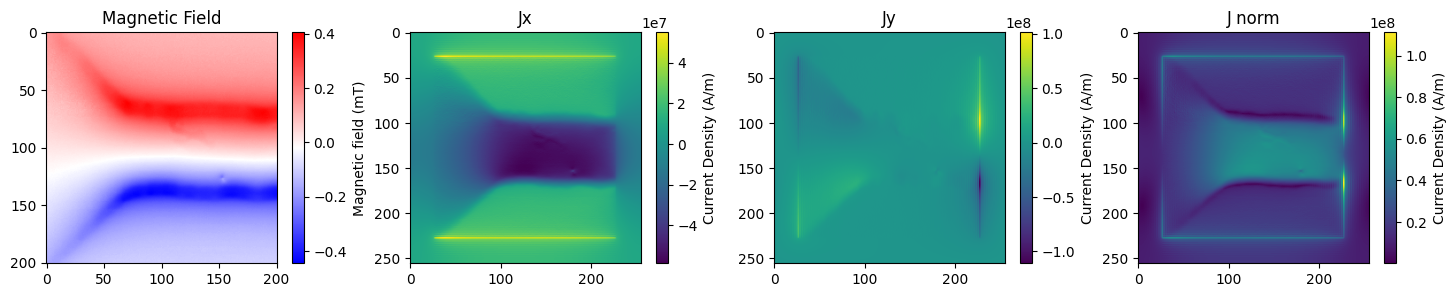

In [3]:
fig = plt.figure()
fig.set_figwidth(18)
fig.set_figheight(3)

plt.subplot(1,4,1)
plt.imshow(1e3*PROP.OriginalMagneticField, cmap = 'bwr')
plt.colorbar(label='Magnetic field (mT)')
plt.title('Magnetic Field')

plt.subplot(1,4,2)
plt.imshow(jx)
plt.title('Jx')
plt.colorbar(label='Current Density (A/m)')

plt.subplot(1,4,3)
plt.imshow(jy)
plt.title('Jy')
plt.colorbar(label='Current Density (A/m)')

plt.subplot(1,4,4)
plt.imshow(j_norm)
plt.title('J norm')
plt.colorbar(label='Current Density (A/m)')


In [4]:
# Make the neural network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Generator = generator_CNN(Size=1, ImageSize=PROP.options['ImageShape'],  channels_in = 1, channels_out=2).to(device)

In [5]:
# Set the machine learning paramaters for keyword unpacking
ML_options = dict()
ML_options['mlp']=False
ML_options['LossFunction']='L1'
ML_options['Magnetization']=None
ML_options['IntegerOnly']=False
ML_options['PositiveMagnetisationOnly']=True
ML_options['PrintLossValue']=False
ML_options['Epochs']= 150

In [6]:
CNN_training = Magnetisation_CNN_training(device, Generator, PROP,ML_options)
bnv_cnn = CNN_training.train_J(**ML_options)

torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])


c:\Users\parax\miniconda3\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([256, 256])) that is different to the input size (torch.Size([1, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size(

In [7]:
# Get the results and plot
Results = CNN_training.extract_results(plotResults = True)

AttributeError: 'Magnetisation_CNN_training' object has no attribute 'ReconMag'

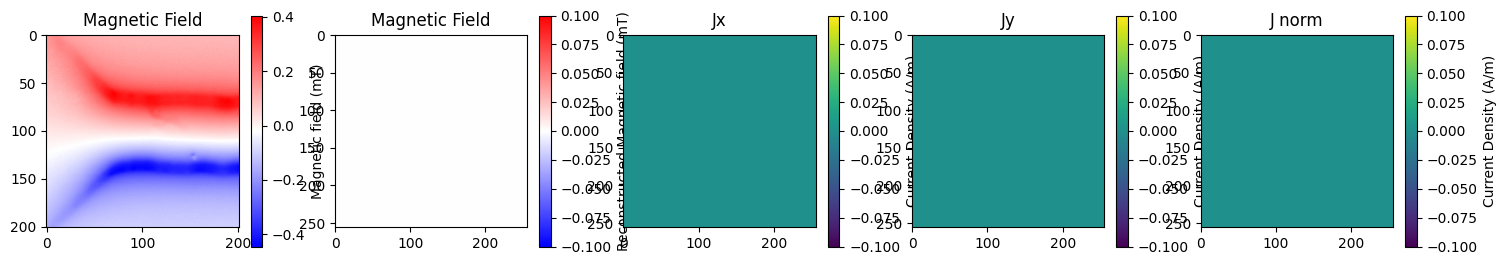

In [9]:
fig = plt.figure()
fig.set_figwidth(18)
fig.set_figheight(3)

plt.subplot(1,5,1)
plt.imshow(1e3*PROP.OriginalMagneticField, cmap = 'bwr')
plt.colorbar(label='Magnetic field (mT)')
plt.title('Magnetic Field')

plt.subplot(1,5,2)
plt.imshow(CNN_training.ReconBnv, cmap = 'bwr')
plt.colorbar(label='Reconstructed Magnetic field (mT)')
plt.title('Magnetic Field')

plt.subplot(1,5,3)
plt.imshow(CNN_training.ReconCurrenetJx)
plt.title('Jx')
plt.colorbar(label='Current Density (A/m)')

plt.subplot(1,5,4)
plt.imshow(CNN_training.ReconCurrenetJy)
plt.title('Jy')
plt.colorbar(label='Current Density (A/m)')

plt.subplot(1,5,5)
plt.imshow(np.sqrt(CNN_training.ReconCurrenetJx**2 + CNN_training.ReconCurrenetJy**2))
plt.title('J norm')
plt.colorbar(label='Current Density (A/m)')
